In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train_df = pd.read_csv('/kaggle/input/titanic/train.csv')
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# What columns do we have
train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [4]:
# Ticket number, cabin number, name and passenger id are going to be unique to each person so not likely to be useful as a feature

train_df.drop(columns=['Cabin', 'Ticket', 'Name', 'PassengerId'], inplace=True)

In [5]:
# What are our column types
train_df.dtypes

Survived      int64
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked     object
dtype: object

In [6]:
# How many null values do we have per column?
train_df.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

In [7]:
# Looking at the values for Embarked, we see most embarked at S. Let's impute this value for the two nulls
train_df.Embarked.value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [8]:
# Impute with S

train_df['Embarked'] = train_df['Embarked'].fillna('S')

Mean age: 29.7
Median age: 28.0


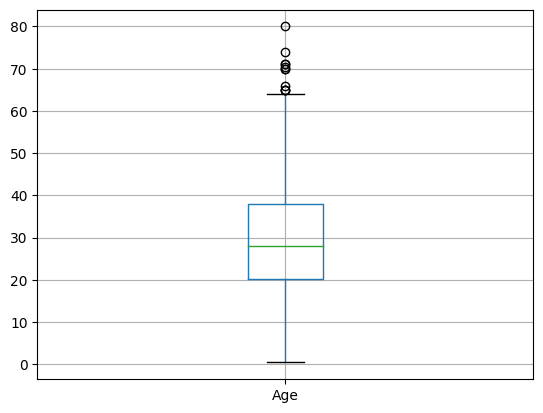

In [9]:
# Let's look at the distribution of ages. We can see that the outliers skew the mean age up, so it's better to use the median age
train_df.boxplot(column='Age')
mean_age = train_df.Age.mean()
median_age = train_df.Age.median()
print(f"Mean age: {mean_age:.3}")
print(f"Median age: {median_age}")

/usr/local/lib/python3.10/dist-packages/pandas/core/groupby/ops.py:911: RuntimeWarning: All-NaN slice encountered
  res = f(group)


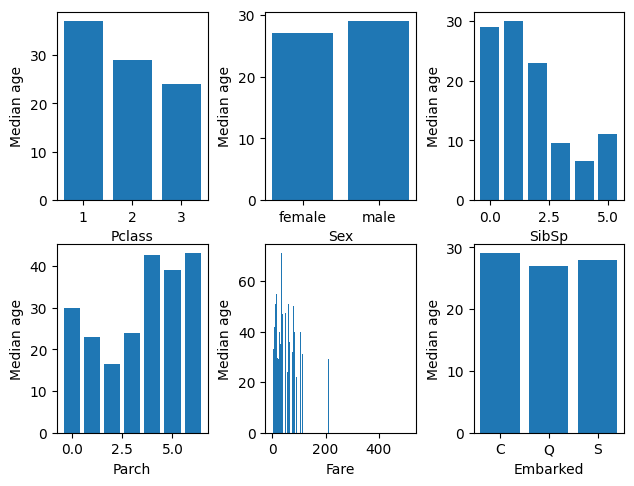

In [10]:
# Instead of filling the nulls with the global medium, let's see if there are any segments we can look at to get a better idea of how to fill this field
# From eyeballing, Class looks to have a big impact with older people having more money to pay for more expensive tickets, so let's segment with that

cols = train_df.columns
variables = cols.drop(['Age','Survived'])

from matplotlib import pyplot as plt
fig, axes = plt.subplots(2,3)
plt.tight_layout()
for i in range(len(variables)):
    group_i = train_df.groupby(variables[i])['Age'].apply(np.nanmedian)
    axes[i//3,i%3].bar(group_i.index, group_i.values)
    axes[i//3,i%3].set(xlabel=group_i.index.name)

for ax in axes.flat:
    ax.set(ylabel='Median age')

Let's take the median for PClass, there seems to be a correlation and with a small number of categories is simple enough

In [11]:
train_df['Age'] = train_df['Age'].fillna(train_df.groupby('Pclass')['Age'].transform('median'))

In [12]:
# Returning again to our dataframe

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [13]:
# We are now going to one hot encode Sex and Embarked

OHC_cols = ['Sex','Embarked']
train_df = pd.get_dummies(data=train_df, prefix=OHC_cols, columns=OHC_cols)
train_df

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,False,True,False,False,True
1,1,1,38.0,1,0,71.2833,True,False,True,False,False
2,1,3,26.0,0,0,7.9250,True,False,False,False,True
3,1,1,35.0,1,0,53.1000,True,False,False,False,True
4,0,3,35.0,0,0,8.0500,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,27.0,0,0,13.0000,False,True,False,False,True
887,1,1,19.0,0,0,30.0000,True,False,False,False,True
888,0,3,24.0,1,2,23.4500,True,False,False,False,True
889,1,1,26.0,0,0,30.0000,False,True,True,False,False


In [14]:
# now the fun begins

y = train_df['Survived']
X = train_df.drop(columns='Survived')

In [15]:
# Split into Train and Validation sets

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Build random forest testing for different hyperparameters
# First declare hyperparameters

# Number of trees 
n_estimators = [int(x) for x in np.linspace(start=10, stop=100, num=10)]

# Num features at each split
# max_features = ['auto','sqrt']

# Max depth of tree
max_depth = [2, 4, 8, 12, None]

# Min samples required to split a node
min_samples_split = [2, 5, 10, 25, 50]

# Min samples required to split a leaf node
min_samples_leaf = [2, 4, 8]

# Method of selecting samples for training each tree
#bootstrap = [True, False]

In [17]:
# Create the parameter grid

param_grid = {
    'n_estimators': n_estimators,
    #'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf
    #'bootstrap': bootstrap
}

print(param_grid)

{'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'max_depth': [2, 4, 8, 12, None], 'min_samples_split': [2, 5, 10, 25, 50], 'min_samples_leaf': [2, 4, 8]}


In [18]:
# Initalise model

from sklearn.ensemble import RandomForestClassifier
rf_Model = RandomForestClassifier()

In [19]:
# Initalise Grid Search

from sklearn.model_selection import GridSearchCV 
rf_Grid = GridSearchCV(estimator=rf_Model, param_grid=param_grid, cv=3, verbose=2, n_jobs=5)

In [20]:
# Fit

rf_Grid.fit(X_train, y_train)

Fitting 3 folds for each of 750 candidates, totalling 2250 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=5,
             param_grid={'max_depth': [2, 4, 8, 12, None],
                         'min_samples_leaf': [2, 4, 8],
                         'min_samples_split': [2, 5, 10, 25, 50],
                         'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                          100]},
             verbose=2)

In [21]:
# What are our best parameters

rf_Grid.best_params_

{'max_depth': 8,
 'min_samples_leaf': 4,
 'min_samples_split': 25,
 'n_estimators': 90}

In [22]:
# Doesn't look to be overfitting - let's predict!

print (f'Train Accuracy - : {rf_Grid.score(X_train,y_train):.3f}')
print (f'Cross Validation Accuracy - : {rf_Grid.score(X_val,y_val):.3f}')

Train Accuracy - : 0.853
Cross Validation Accuracy - : 0.799


In [23]:
# Pull in test data

test_data = pd.read_csv('/kaggle/input/titanic/test.csv')
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [24]:
# What null values do we need to impute for the test data

test_data.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [25]:
# Let us drop irrelevant columns

X_test = test_data.drop(columns=['Name', 'Cabin', 'Ticket', 'PassengerId'])
X_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S


In [26]:
# Let us impute the ages as before

X_test = X_test.merge(train_df.groupby('Pclass')['Age'].apply(np.nanmedian), how='left', on='Pclass')
X_test['Age'] = X_test.Age_x.combine_first(X_test.Age_y)
X_test.drop(columns=['Age_x','Age_y'], inplace=True)
X_test.head()

,Pclass,Sex,SibSp,Parch,Fare,Embarked,Age
0,3,male,0,0,7.8292,Q,34.5
1,3,female,1,0,7.0000,S,47.0
2,2,male,0,0,9.6875,Q,62.0
3,3,male,0,0,8.6625,S,27.0
4,3,female,1,1,12.2875,S,22.0


In [27]:
# Let's use the median fare per class also to impute the missing fare

X_test = X_test.merge(train_df.groupby('Pclass')['Fare'].apply(np.nanmedian), how='left', on='Pclass')
X_test['Fare'] = X_test.Fare_x.combine_first(X_test.Fare_y)
X_test.drop(columns=['Fare_x','Fare_y'], inplace=True)
X_test.head()

,Pclass,Sex,SibSp,Parch,Embarked,Age,Fare
0,3,male,0,0,Q,34.5,7.8292
1,3,female,1,0,S,47.0,7.0000
2,2,male,0,0,Q,62.0,9.6875
3,3,male,0,0,S,27.0,8.6625
4,3,female,1,1,S,22.0,12.2875


In [28]:
# Doublecheck null values

X_test.isnull().sum()

Pclass      0
Sex         0
SibSp       0
Parch       0
Embarked    0
Age         0
Fare        0
dtype: int64

In [29]:
# OHC categorical columns

X_test = pd.get_dummies(data=X_test, prefix=OHC_cols, columns=OHC_cols)

In [30]:
# Reorder columns

X_test = X_test[X_train.columns]
X_test.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,34.5,0,0,7.8292,False,True,False,True,False
1,3,47.0,1,0,7.0000,True,False,False,False,True
2,2,62.0,0,0,9.6875,False,True,False,True,False
3,3,27.0,0,0,8.6625,False,True,False,False,True
4,3,22.0,1,1,12.2875,True,False,False,False,True


In [31]:
print('X_Test shape: ', X_test.shape)
print('test_Data shape: ', test_data.shape)

X_Test shape:  (418, 10)
test_Data shape:  (418, 11)


In [32]:
# Predictions

predictions = rf_Grid.predict(X_test)

In [33]:
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
output.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
